In [1]:
# Dependencies and setup
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import torch as th
import os
import cv2
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

import time

import shutil

import os

from google.colab.patches import cv2_imshow

from google.colab import drive
# drive.mount('/content/drive')
root = '/content/Data'

In [ ]:
!unzip -u /content/Data.zip

In [4]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [25]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
robot_log_training = pd.read_csv(os.path.join(root, 'Training', 'robot_log.csv'), index_col = 'Path')
robot_log_test     = pd.read_csv(os.path.join(root, 'Test', 'robot_log.csv'), index_col = 'Path')

n_training_samples = len(robot_log_training) 
n_val_samples = len(robot_log_test)

print(f'Training n = {n_training_samples}')
print(f'Test n = {n_val_samples}')

Training n = 9914
Test n = 2504


In [6]:
# Begin loading in images in IMG folder
# Move them into a "Classified" folder which allows torch to read them into datasets

'''
Classification into bins
SteerAngle: -, 0, +
Throttle: -, 0, +

Steer/Throttle
0: -/-
1: -/0
2: -/+
3: 0/-
4: 0/0
5: 0/+
6: +/-
7: +/0
8: +/+
'''
def return_classifier(image, robot_log):
  try:
    steer = float(robot_log['SteerAngle'][image])
    throttle = float(robot_log['Throttle'][image])

    if np.sign(steer) == -1:
      if np.sign(throttle) == -1:
        return 0
      elif np.sign(throttle) == 0:
        return 1
      elif np.sign(throttle) == 1:
        return 2
    elif np.sign(steer) == 0:
      if np.sign(throttle) == -1:
        return 3
      elif np.sign(throttle) == 0:
        return 4
      elif np.sign(throttle) == 1:
        return 5
    elif np.sign(steer) == 1:
      if np.sign(throttle) == -1:
        return 6
      elif np.sign(throttle) == 0:
        return 7
      elif np.sign(throttle) == 1:
        return 8
  except:
    print(f'Failed to copy over image {image}')

train_dict = {}
test_dict = {}

for folder in ['Training', 'Test']:
  image_dir = os.path.join(root, folder, 'IMG')

  for image in os.listdir(image_dir):
    if folder == 'Training':
      classifier = return_classifier(image, robot_log_training)
    elif folder == 'Test':
      classifier = return_classifier(image, robot_log_test)

    target_path = os.path.join(os.path.join(root, folder, "Classified"), str(classifier))
    exists = os.path.exists(target_path)
    
    if not exists:
      # Create a new directory because it does not exist 
      os.makedirs(target_path)

    # Copy images into classified folders  
    shutil.copy(os.path.join(root, folder, "IMG", image), target_path)

In [12]:
print('Number of images per discretized bin: \n')

for dataset in ['Training', 'Test']:
  print(dataset)
  for dir in range(0,8):
      print(f'* Bin {dir}, n = '+ str(len(os.listdir(os.path.join(root, dataset,"Classified", str(dir))))))

Number of images per discretized bin: 

Training
* Bin 0, n = 180
* Bin 1, n = 954
* Bin 2, n = 595
* Bin 3, n = 114
* Bin 4, n = 3808
* Bin 5, n = 2068
* Bin 6, n = 243
* Bin 7, n = 1364
Test
* Bin 0, n = 87
* Bin 1, n = 190
* Bin 2, n = 48
* Bin 3, n = 78
* Bin 4, n = 948
* Bin 5, n = 475
* Bin 6, n = 22
* Bin 7, n = 599


In [17]:
# Define CNN

class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 200) 
        self.fc3 = nn.Linear(200, 200) 
        self.fc4 = nn.Linear(200, 64) 
        self.fc5 = nn.Linear(64, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 18 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [19]:
num_workers = 2
test_batch_size = 64

# Transform the images to normalize them and downsample
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     transforms.Resize((32,32))])

train_set = torchvision.datasets.ImageFolder(root=os.path.join(root, 'Training', 'Classified'), transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size,
                                          num_workers=num_workers)

test_set = torchvision.datasets.ImageFolder(root=os.path.join(root, 'Test', 'Classified'), transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

from torch.utils.data.sampler import SubsetRandomSampler

# Assume 1000 validation images
n_training_samples = len(train_set) - 1000 
n_val_samples = 1000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples+ n_val_samples, dtype=np.int64))

In [15]:
# Quick fix, sometimes a hidden directory is created that messes up the torch dataset initialization
!rm -R /content/Data/Training/Classified/.ipynb_checkpoints
!ls /content/Data/Training/Classified -a   #to make sure that the deletion has occurred
!rm -R /content/Data/Test/Classified/.ipynb_checkpoints
!ls /content/Data/Test/Classified -a   #to make sure that the deletion has occurred

rm: cannot remove '/content/Data/Training/Classified/.ipynb_checkpoints': No such file or directory
.  ..  0  1  2	3  4  5  6  7  8
rm: cannot remove '/content/Data/Test/Classified/.ipynb_checkpoints': No such file or directory
.  ..  0  1  2	3  4  5  6  7  8


In [20]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# # Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=313, sampler=val_sampler,
                                          num_workers=num_workers)

def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        opt_end = time.time()
        for i, (inputs, labels) in enumerate(train_loader):          
            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()
            # print every 10th of epoch

            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

            opt_end = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    # net.load_state_dict(th.load(best_model_path))

    return train_history, val_history

In [21]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

net = SimpleConvolutionalNetwork()

train_history, val_history = train(net, batch_size=32, n_epochs=15, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 15
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.66 took: 1.72s
Epoch 1, 20% 	 train_loss: 1.54 took: 1.23s
Epoch 1, 30% 	 train_loss: 1.52 took: 1.24s
Epoch 1, 40% 	 train_loss: 1.49 took: 1.30s
Epoch 1, 50% 	 train_loss: 1.41 took: 1.29s
Epoch 1, 60% 	 train_loss: 1.36 took: 1.26s
Epoch 1, 70% 	 train_loss: 1.33 took: 1.25s
Epoch 1, 80% 	 train_loss: 1.24 took: 1.29s
Epoch 1, 90% 	 train_loss: 1.30 took: 1.29s
Validation loss = 10.14
Epoch 2, 10% 	 train_loss: 1.17 took: 1.42s
Epoch 2, 20% 	 train_loss: 1.26 took: 1.28s
Epoch 2, 30% 	 train_loss: 1.17 took: 1.21s
Epoch 2, 40% 	 train_loss: 1.13 took: 1.23s
Epoch 2, 50% 	 train_loss: 1.15 took: 1.23s
Epoch 2, 60% 	 train_loss: 1.13 took: 1.31s
Epoch 2, 70% 	 train_loss: 1.18 took: 1.30s
Epoch 2, 80% 	 train_loss: 1.12 took: 1.24s
Epoch 2, 90% 	 train_loss: 1.13 took: 1.24s
Validation loss = 10.23
Epoch 3, 10% 	 train_loss: 1.06 took: 1.39s
Epoch 3, 20% 	 train_loss: 1.03 took: 1

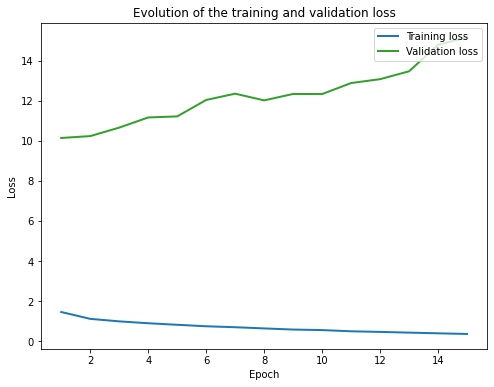

In [26]:
plot_losses(train_history, val_history)

In [27]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8')

def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 9914 train images: 81.48 %
Accuracy of the network on the 1000 validation images: 7.60 %
Accuracy of the network on the 2504 test images: 42.45 %


In [28]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 9
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(predicted.size(0)):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
0            31.03   
1            23.68   
2             0.00   
3            14.10   
4            64.56   
5            46.32   
6            59.09   
7            22.54   
8             0.00   


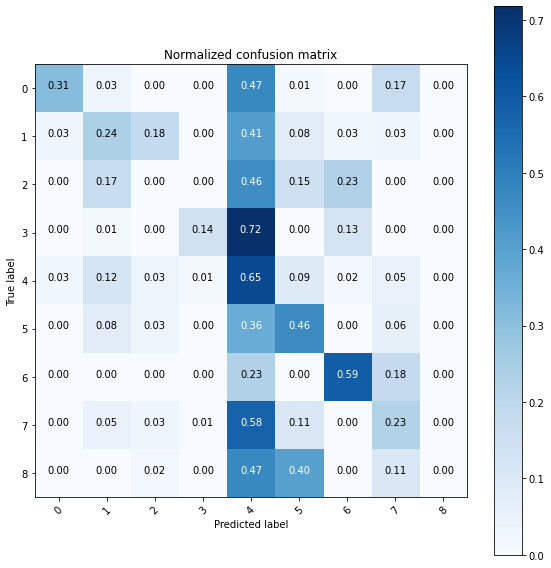

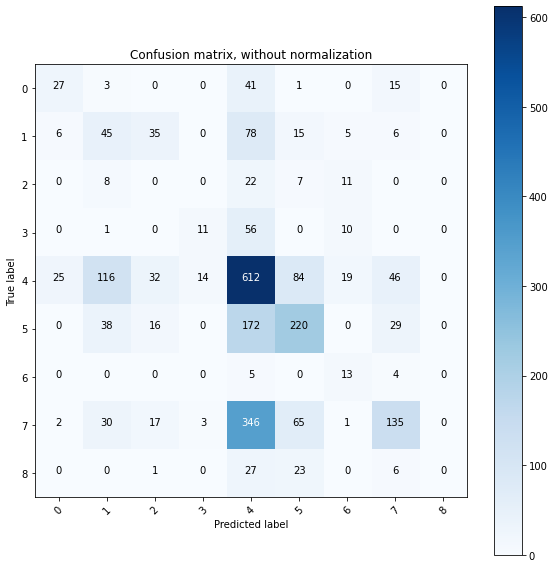

In [29]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')